In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, count
import matplotlib.pyplot as plt
import seaborn as sns

# Crear la sesión de Spark
spark = SparkSession.builder.appName("DataAnalysis").getOrCreate()

# Cargar los datos
arrestos_df = spark.read.csv('/FileStore/tables/arrestos_limpio.csv', header=True, inferSchema=True)
pobreza_df = spark.read.csv('/FileStore/tables/pobreza_limpio.csv', header=True, inferSchema=True)

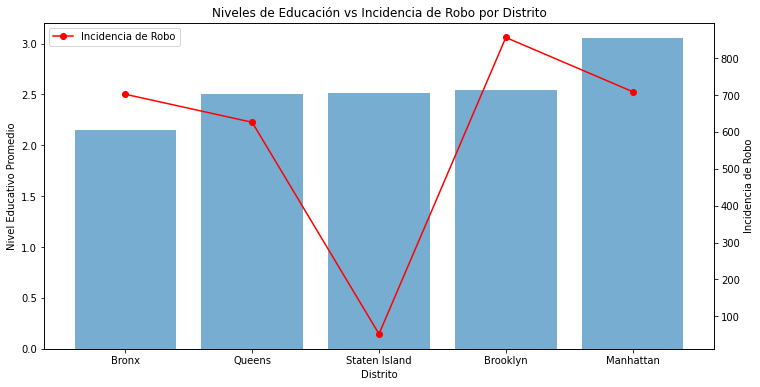

In [0]:
# Análisis 1: Niveles de educación y áreas con mayor incidencia de robo

# Filtrar y agrupar los datos de robos por distrito
robos_por_distrito = arrestos_df.filter(col('OFNS_DESC') == 'ROBBERY') \
    .groupBy('ARREST_BORO') \
    .agg(count('*').alias('Incidencia_Robo'))

# Agrupar los datos de pobreza por distrito y calcular el promedio del nivel educativo
educacion_por_distrito = pobreza_df.groupBy('Borough') \
    .agg(avg('nivel_educativo').alias('nivel_educativo'))

# Unir ambos dataframes
educacion_robos_df = educacion_por_distrito.join(robos_por_distrito, educacion_por_distrito.Borough == robos_por_distrito.ARREST_BORO)

# Convertir a Pandas para graficar
educacion_robos_pd = educacion_robos_df.toPandas().sort_values(by='nivel_educativo')

# Graficar
plt.figure(figsize=(12, 6))
plt.bar(educacion_robos_pd['Borough'], educacion_robos_pd['nivel_educativo'], alpha=0.6, label='Nivel Educativo Promedio')
plt.ylabel('Nivel Educativo Promedio')
plt.xlabel('Distrito')
plt.twinx()
plt.plot(educacion_robos_pd['Borough'], educacion_robos_pd['Incidencia_Robo'], color='red', marker='o', label='Incidencia de Robo')
plt.ylabel('Incidencia de Robo')
plt.title('Niveles de Educación vs Incidencia de Robo por Distrito')
plt.legend(loc='upper left')
plt.show()

<Figure size 864x432 with 0 Axes>

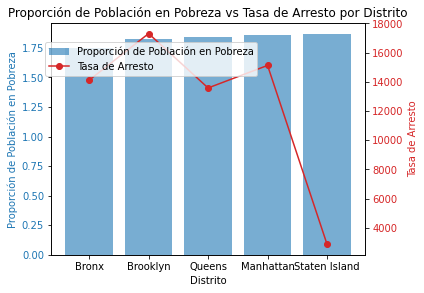

In [0]:
# Análisis 2: Pobreza y tasas de arresto

# Calcular la proporción de población en situación de pobreza por distrito
pobreza_por_distrito = pobreza_df.groupBy('Borough') \
    .agg(avg('Estatus_Pobreza').alias('Estatus_Pobreza'))

# Calcular la tasa de arresto por distrito
tasa_arresto_por_distrito = arrestos_df.groupBy('ARREST_BORO') \
    .agg(count('*').alias('Tasa_Arresto'))

# Unir ambos dataframes
pobreza_arrestos_df = pobreza_por_distrito.join(tasa_arresto_por_distrito, pobreza_por_distrito.Borough == tasa_arresto_por_distrito.ARREST_BORO)

# Convertir a Pandas para graficar
pobreza_arrestos_pd = pobreza_arrestos_df.toPandas().sort_values(by='Estatus_Pobreza')

# Graficar
plt.figure(figsize=(12, 6))
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Distrito')
ax1.set_ylabel('Proporción de Población en Pobreza', color=color)
ax1.bar(pobreza_arrestos_pd['Borough'], pobreza_arrestos_pd['Estatus_Pobreza'], color=color, alpha=0.6, label='Proporción de Población en Pobreza')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Tasa de Arresto', color=color)  
ax2.plot(pobreza_arrestos_pd['Borough'], pobreza_arrestos_pd['Tasa_Arresto'], color=color, marker='o', label='Tasa de Arresto')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title('Proporción de Población en Pobreza vs Tasa de Arresto por Distrito')
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.show()

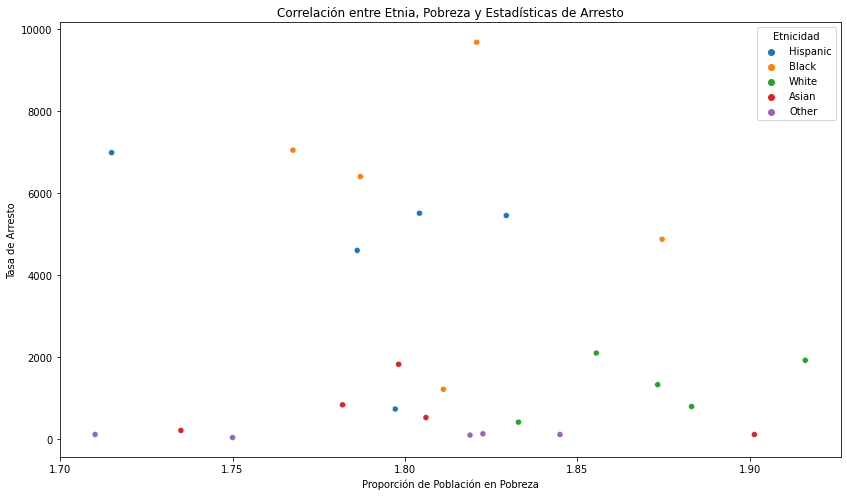

In [0]:
# Análisis 3: Correlación entre etnia, pobreza y estadísticas de arresto

# Agrupar los datos de pobreza por distrito y etnia
pobreza_etnia_df = pobreza_df.groupBy('Borough', 'Etnicidad') \
    .agg(avg('Estatus_Pobreza').alias('Estatus_Pobreza'))

# Agrupar los datos de arrestos por distrito y etnia
arrestos_etnia_df = arrestos_df.groupBy('ARREST_BORO', 'PERP_RACE') \
    .agg(count('*').alias('Tasa_Arresto'))

# Unir ambos dataframes
pobreza_arrestos_etnia_df = pobreza_etnia_df.join(arrestos_etnia_df, (pobreza_etnia_df.Borough == arrestos_etnia_df.ARREST_BORO) & (pobreza_etnia_df.Etnicidad == arrestos_etnia_df.PERP_RACE))

# Convertir a Pandas para graficar
pobreza_arrestos_etnia_pd = pobreza_arrestos_etnia_df.toPandas()

# Graficar
plt.figure(figsize=(14, 8))
sns.scatterplot(data=pobreza_arrestos_etnia_pd, x='Estatus_Pobreza', y='Tasa_Arresto', hue='Etnicidad')
plt.xlabel('Proporción de Población en Pobreza')
plt.ylabel('Tasa de Arresto')
plt.title('Correlación entre Etnia, Pobreza y Estadísticas de Arresto')
plt.legend(title='Etnicidad')
plt.show()

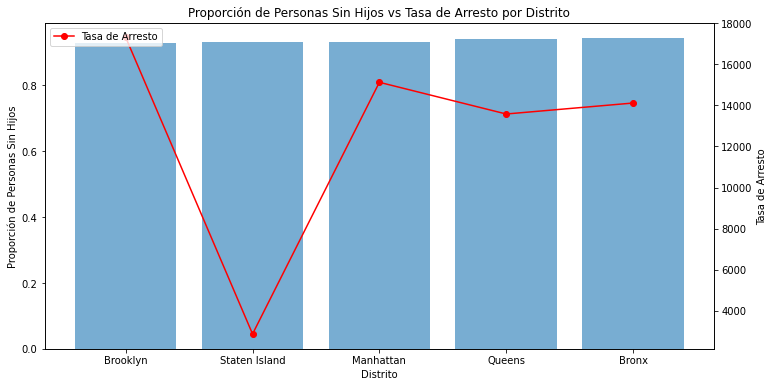

In [0]:
# Análisis 4: Personas sin hijos y áreas con índices de arresto

# Calcular la proporción de personas sin hijos por distrito
sin_hijos_por_distrito = pobreza_df.groupBy('Borough') \
    .agg(avg('Tiene_Hijos').alias('Proporcion_Con_Hijos'))
sin_hijos_por_distrito = sin_hijos_por_distrito.withColumn('Proporcion_Sin_Hijos', 1 - col('Proporcion_Con_Hijos'))

# Unir con las tasas de arresto por distrito
sin_hijos_arrestos_df = sin_hijos_por_distrito.join(tasa_arresto_por_distrito, sin_hijos_por_distrito.Borough == tasa_arresto_por_distrito.ARREST_BORO)

# Convertir a Pandas para graficar
sin_hijos_arrestos_pd = sin_hijos_arrestos_df.toPandas().sort_values(by='Proporcion_Sin_Hijos')

# Graficar
plt.figure(figsize=(12, 6))
plt.bar(sin_hijos_arrestos_pd['Borough'], sin_hijos_arrestos_pd['Proporcion_Sin_Hijos'], alpha=0.6, label='Proporción de Personas Sin Hijos')
plt.ylabel('Proporción de Personas Sin Hijos')
plt.xlabel('Distrito')
plt.twinx()
plt.plot(sin_hijos_arrestos_pd['Borough'], sin_hijos_arrestos_pd['Tasa_Arresto'], color='red', marker='o', label='Tasa de Arresto')
plt.ylabel('Tasa de Arresto')
plt.title('Proporción de Personas Sin Hijos vs Tasa de Arresto por Distrito')
plt.legend(loc='upper left')
plt.show()
